# 3D spectral analysis of HESS J1745-290 (with HAP-hd)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time
from pathlib import Path

In [10]:

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets
from gammapy.estimators import ExcessMapEstimator

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    SkyModel,
    FoVBackgroundModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    Models
)

#from gammapy.stats import significance, excess # utiles ?

import gammapy
gammapy.__version__

'0.18.2'

In [11]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [12]:
# General path (to select which analysis/set of data we work with)
path = Path("../../../../gammapy_data/GC_variability2020/hap-hd")
path.mkdir(exist_ok=True)

# To find the model template
pathm = Path(path/"models")
pathm.mkdir(exist_ok=True)

model_name = pathm/"models_template_2cutoff.yaml"

# Directory for outputs
path3d = Path(path/"3Dspectra")
path3d.mkdir(exist_ok=True)

In [13]:
pathtry = Path(path3d/"2amps_2indexes_1cutoff_bis")
pathtry.mkdir(exist_ok=True)

## Creating the geometry

In [17]:
# pas utile

emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="GAL",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

TypeError: create() got an unexpected keyword argument 'coordsys'

In [18]:
# Creating the total dataset (potentially useless)

#mapdataset_tot = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

filename = "mapdatasets/mapdataset_tot.fits.gz"
mapdataset_tot = MapDataset.read(path/filename)

NameError: name 'geom' is not defined

In [15]:
# Creating the three period datasets

#mapdataset_hess1 = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

filename = "mapdatasets/mapdataset_hess1.fits.gz"
mapdataset_hess1 = MapDataset.read(path/filename)


#mapdataset_hess2 = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

filename = "mapdatasets/mapdataset_hess2.fits.gz"
mapdataset_hess2 = MapDataset.read(path/filename)


#mapdataset_hess1u = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

filename = "mapdatasets/mapdataset_hess1u.fits.gz"
mapdataset_hess1u = MapDataset.read(path/filename)

ValueError: Incorrect energy axis position in input Map

## Reading the model template

In [7]:
modelGC,modelG09, model_diff = Models.read(model_name)

## Setting which parameters will vary

In [8]:
modelGC.parameters["index"].frozen = False
modelGC.parameters["index"].value = 1.87

modelGC.parameters["lon_0"].frozen = True
modelGC.parameters["lat_0"].frozen = True
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["reference"].frozen = True 

modelG09.parameters["index"].frozen = True
modelG09.parameters["lon_0"].frozen = True
modelG09.parameters["lat_0"].frozen = True
modelG09.parameters["amplitude"].frozen = False

model_diff.parameters["index"].frozen = False
model_diff.parameters["index"].value = 2.32

model_diff.parameters["norm"].frozen = True
model_diff.parameters["amplitude"].frozen = False
model_diff.parameters["reference"].frozen = True

In [9]:
# if there are cutoffs in the spectra

modelGC.parameters["lambda_"].frozen = False
modelGC.parameters["lambda_"].value = 1/8.0
model_diff.parameters["lambda_"].frozen = True
model_diff.parameters["lambda_"].value = 0.0

## Constructing the mask

In [10]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

#éventuellement étendre le masque

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Function used to fit a given dataset

In [11]:
def fit_dataset(fit):

    result = fit.run()
    
    table = result.parameters.to_table()
    
    return table, result

# Fitting the many datasets

Stacking all three datasets tends to give poor results, trying to fit HESS1+2 on the one hand, and HESS1U on the other might be more succesful.

### Fitting the dataset for each period separately

In [12]:
#%%time

#mapdataset_hess1.fit_mask = fit_mask
#mapdataset_hess1.models =  modelGC.copy() + modelG09.copy()+ model_diff.copy()
#mapdataset_hess1.background_model.parameters['norm'].value = 1.0

#mapdataset_hess2.fit_mask = fit_mask
#mapdataset_hess2.models =  modelGC.copy() + modelG09.copy()+ model_diff.copy()
#mapdataset_hess2.background_model.parameters['norm'].value = 1.0

#mapdataset_hess1u.fit_mask = fit_mask
#mapdataset_hess1u.models =  modelGC.copy() + modelG09.copy()+ model_diff.copy()
#mapdataset_hess1u.background_model.parameters['norm'].value = 1.0

#fit1 = Fit([mapdataset_hess1])
#table1,  result1 = fit_dataset(fit1)

#models_hess1 = mapdataset_hess1.models.copy()

#fit2 = Fit([mapdataset_hess2])
#table2,  result2 = fit_dataset(fit2)

#models_hess2 = mapdataset_hess2.models.copy()

#fit1u = Fit([mapdataset_hess1u])
#table1u,  result1u = fit_dataset(fit1u)

#models_hess1u = mapdataset_hess1u.models.copy()

### Fitting the joint dataset

In [13]:
joint_dataset = [mapdataset_hess1, mapdataset_hess2, mapdataset_hess1u]
models_joint =  modelGC.copy() + modelG09.copy()+ model_diff.copy()

for dataset in joint_dataset:
    
    models = models_joint
    models.append(FoVBackgroundModel(dataset_name=dataset.name))
    
    dataset.models = models_joint
    dataset.fit_mask = fit_mask
    dataset.background_model.parameters['norm'].value = 1.0

In [13]:
%%time
fit_joint = Fit(joint_dataset)
table_joint, result_joint = fit_dataset(fit_joint)

CPU times: user 9min 33s, sys: 47.6 s, total: 10min 20s
Wall time: 10min 21s


### Fitting the stacked dataset

### Fitting the 'total dataset' (probably the same as above) 

In [182]:
#%%time

#mapdataset_tot.fit_mask = fit_mask
#mapdataset_tot.models =  modelGC.copy() + modelG09.copy()+ model_diff.copy()
#mapdataset_tot.background_model.parameters['norm'].value = 1.0


#fit_tot = Fit([mapdataset_tot])
#table_tot, result_tot = fit_dataset(fit_tot)

### Adding (covariance computed) errors to the model objects, shouldn't be necessary post-0.15 versions

In [183]:
#models_hess1[0].spectral_model.parameters.covariance = (
#    result1.parameters.covariance[2:7,2:7])

#models_hess1[2].spectral_model.parameters.covariance = (
#    result1.parameters.covariance[13:18,13:18])


#models_hess2[0].spectral_model.parameters.covariance = (
#    result2.parameters.covariance[2:7,2:7])

#models_hess2[2].spectral_model.parameters.covariance = (
#    result2.parameters.covariance[13:18,13:18])


#models_hess1u[0].spectral_model.parameters.covariance = (
#    result1u.parameters.covariance[2:7,2:7])

#models_hess1u[2].spectral_model.parameters.covariance = (
#    result1u.parameters.covariance[13:18,13:18])

In [184]:
#mapdataset_tot.models[0].spectral_model.parameters.covariance = (
#    result_tot.parameters.covariance[2:7,2:7])

#mapdataset_tot.models[2].spectral_model.parameters.covariance = (
#    result_tot.parameters.covariance[13:18,13:18])

In [14]:
models_joint[0].spectral_model.parameters.covariance = (
    result_joint.parameters.covariance[2:7,2:7])

models_joint[2].spectral_model.parameters.covariance = (
    result_joint.parameters.covariance[13:18,13:18])

## Results

### Spectrum

In [15]:
def plot_spectrum(models, path ,namefile, name):
    plt.figure(figsize=(10,8))
    plot_kwargs = {
        "energy_range": [0.1, 30] * u.TeV,
        "energy_power": 2,
        "flux_unit": "erg-1 cm-2 s-1",
    }

    ## central source
    index = models[0].spectral_model.parameters["index"].value
    amp = models[0].spectral_model.parameters["amplitude"].value
    
    if models[0].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[0].spectral_model.parameters["lambda_"].value
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"diffuse      : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff))
    else :  
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"diffuse      : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[0].spectral_model.plot_error(**plot_kwargs)

    
    ## diffuse model
    index = models[2].spectral_model.parameters["index"].value
    amp = models[2].spectral_model.parameters["amplitude"].value
    
    if models[2].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[2].spectral_model.parameters["lambda_"].value
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse      : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff ))
    else :  
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse      : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[2].spectral_model.plot_error(**plot_kwargs)

    plt.title("Spectral models fitted for a constant GC source (" + name + ")")
    plt.legend()
    plt.savefig(path/namefile)

In [187]:
#plot_spectrum(mapdataset_tot.models, pathtry,"stacked_model_2cutoff_hd.pdf", "stacked")

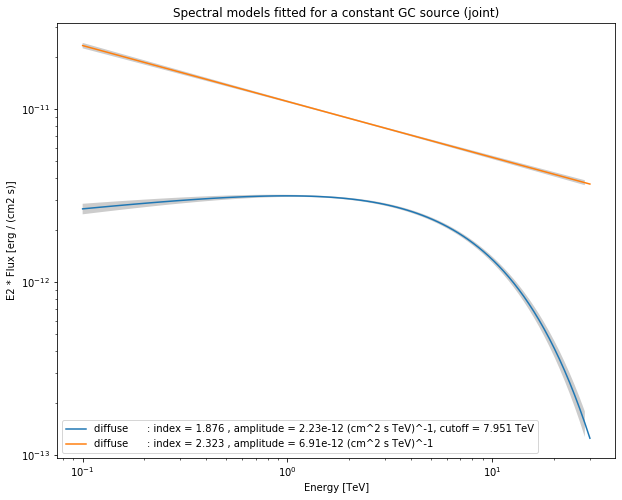

In [16]:
plot_spectrum(models_joint, pathtry,"joint_model_1cutoff_hd.pdf", "joint")

## Flux points

In [22]:
from gammapy.spectrum import FluxPoints, FluxPointsDataset, FluxPointsEstimator

In [18]:
def FluxPointsFitting(dataset, e_edges):
    # this function has to be given the number of the source model in case of multiple models
    # more parameters exist to initialise the estimator
    fpe = FluxPointsEstimator(datasets=dataset, e_edges=e_edges, source=0) 
    flux_points = fpe.run()
    return flux_points

In [19]:
e_min, e_max = 0.5, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

In [20]:
flux_points = FluxPointsFitting(joint_dataset, e_edges)

In [21]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=models_joint[0]
)

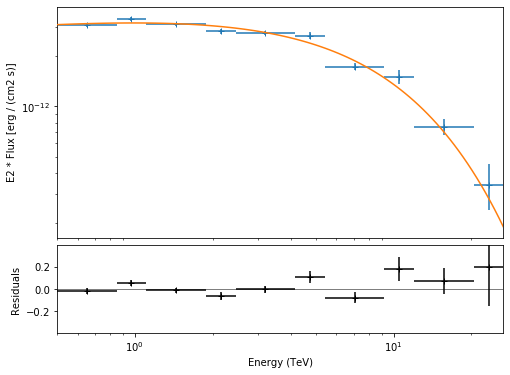

In [23]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek();
plt.savefig(pathtry/"fluxpoints_v_model_joint.pdf")

## Maps

In [30]:
mapdataset_tot.models = models_joint

In [48]:
pathmap = Path(pathtry/"maps")
pathmap.mkdir(exist_ok=True)

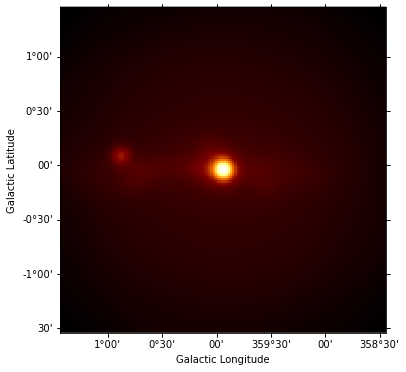

In [49]:
plt.figure(figsize=(6,6))
mapdataset_tot.npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
plt.savefig(pathmap/"model_tot_map.pdf")

## Residuals

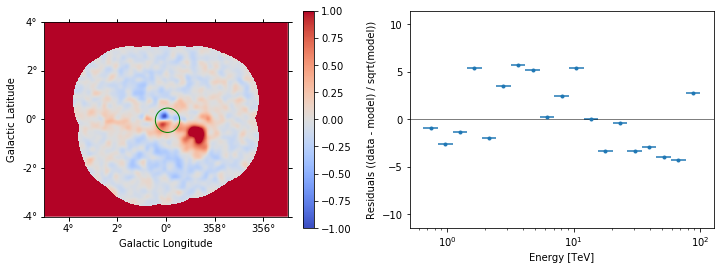

In [50]:
region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

pathr = Path(path/"residuals")
pathr.mkdir(exist_ok=True)

mapdataset_tot.plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
name = "residuals_tot.pdf"
plt.title("")
plt.savefig(pathmap/name, overwrite=True)

## Significance map

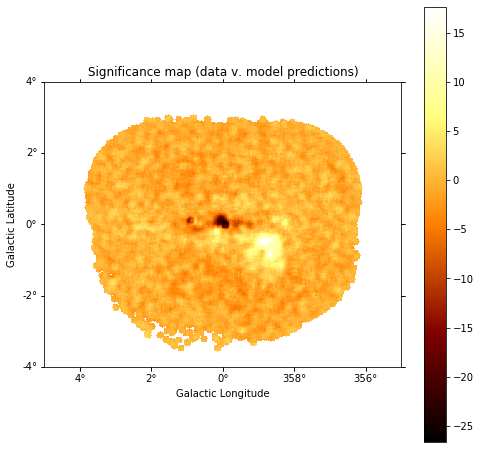

In [51]:
paths = Path(path/"significance")
paths.mkdir(exist_ok=True)

kernel = Tophat2DKernel(5)

plt.figure(figsize=(8,8))
counts = mapdataset_tot.counts.sum_over_axes()
mod = mapdataset_tot.npred().sum_over_axes()
lima_significance = compute_lima_image(counts, mod, kernel)
    
lima_significance['significance'].plot(add_cbar=True)
name = "significance_map_tot.pdf"
plt.title("Significance map (data v. model predictions)")
plt.savefig(pathmap/name, overwrite=True)

## Significance distribution

Text(0.5, 1.0, 'Significance distribution for the central (3°,2°)')

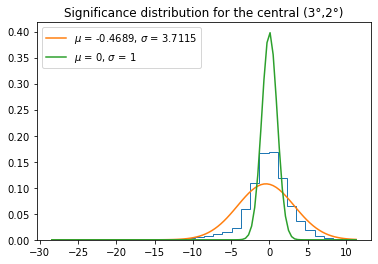

In [61]:
plt.figure()
signidata = lima_significance['significance'].cutout(position=src_pos, width=(3 * u.deg, 2* u.deg)).data
    
# on masque la région en bas à droite
mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 2 * u.deg)).data

plt.hist(signidata[mask].flatten(),30, histtype='step', density=True)
    
mean,std=norm.fit(signidata[mask])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
y2= norm.pdf(x, 0, 1)   
plt.plot(x, y2 ,label=r'$\mu$ = 0, $\sigma$ = 1')

plt.legend()
    
name = "significance_distribution_tot.pdf"
plt.title("Significance distribution for the central (3°,2°)")
#plt.savefig(pathmap/name, overwrite=True)

## Properly estimating the error on parameters (using likelihood)

In [195]:
with open(pathtry/'errors.txt', "a") as out:
    out.write("")

In [196]:
%%time

param = models_joint[0].spectral_model.parameters["index"]

if param.frozen == False:
    fit = Fit(joint_dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)
    
    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "GC index = {0:03.3f}, errp = {1:03.3f}, errn = {2:03.3f}, err_naive = {3:03.3f}".format(
                param.value, confresult['errp'], confresult['errp'], table_joint['error'][2]
            )  + "\n"
        )

CPU times: user 14min 57s, sys: 5.23 s, total: 15min 2s
Wall time: 15min 3s


In [197]:
%%time

param = models_joint[2].spectral_model.parameters["index"]

if param.frozen == False:
    fit = Fit(joint_dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "DE index = {0:03.3f}, errp = {1:03.3f}, errn = {2:03.3f}, err_naive = {3:03.3f}".format(
                param.value, confresult['errp'], confresult['errp'], table_joint['error'][13]
            )  + "\n"
        )

CPU times: user 14min 46s, sys: 636 ms, total: 14min 47s
Wall time: 14min 46s


In [198]:
%%time

param = models_joint[0].spectral_model.parameters["lambda_"]

if param.frozen == False:
    fit = Fit(joint_dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "GC lambda = {0:03.4f}, errp = {1:03.4f}, errn = {2:03.4f}, err_naive = {3:03.4f}".format(
                param.value, confresult['errp'], confresult['errp'], table_joint['error'][5]
            )  + "\n"
        )

CPU times: user 15min 5s, sys: 602 ms, total: 15min 6s
Wall time: 21min 42s


In [199]:
%%time

param = models_joint[2].spectral_model.parameters["lambda_"]

if param.frozen == False:
    
    fit = Fit(joint_dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "DE lambda = {0:03.4f}, errp = {1:03.4f}, errn = {2:03.4f}, err_naive = {3:03.4f}".format(
            param.value, confresult['errp'], confresult['errp'], table_joint['error'][16]
        )  + "\n"
    )

CPU times: user 15min 9s, sys: 596 ms, total: 15min 10s
Wall time: 15min 10s


In [53]:
param = models_joint[0].spectral_model.parameters["amplitude"]

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "GC ampli = {0:03.4e}, err_naive = {1:03.4e}".format(
            param.value, table_joint['error'][3]
        )  + "\n"
    )


param = models_joint[2].spectral_model.parameters["amplitude"]

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "DE ampli = {0:03.4e}, err_naive = {1:03.4e}".format(
            param.value, table_joint['error'][14]
        )  + "\n"
    )

In [55]:
table_joint['unit'][3]

'cm-2 s-1 TeV-1'